# Задание 1


### Целью этого задания является знакомство со стандартными контейнерами и некторыми функциями из стандартных библиотек для машинного обучения.

Напишите наивный байесовский классификатор и сравните его с реализацией NaiveBayesClassifier из библиотеки nltk.

Написанный вами классификатор должен обладать следубщими свойствами:
<ul>
<li>В предложенном интерфейсе класса должны быть реализованы все методы и все поля. Для их хранения предподсчитанных данных рекомендуется использовать контейнеры Counter или defaultdict из библиотеки collections. Для предсказания категории рекомендуется использовать numpy.</li>
<li>Должна использоваться модель, предложенная в теории.</li>
<li>Точность предсказаний не менее <b>0.9</b>!</li>
<li>После реализации класса протестируйте его с помощью кроссвалидации с k=10. Рекомендуется использовать класс KFold из библиотеки sklearn.</li>
<li>Постройте постройте диаграмму размаха для классификаторов (своего и из библиотеки).</li>
</ul>

### Теория

Теория находится в файле problems1-theory.pdf

# Решение

In [83]:
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
from sklearn.cross_validation import KFold
from sklearn.metrics import accuracy_score
from nltk import NaiveBayesClassifier
from matplotlib import pyplot as plt
import tqdm
import operator
import nltk
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import csv

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Прочитайте данные из файла

In [84]:
data_path = "ham-spam.csv"

In [99]:
x_message = []
y_target = []
with open(data_path, mode='r') as f:
    next(f)
    for row in f:
        target, message = row.split(',', maxsplit=1)
        x_message.append(message.lower())
        y_target.append(target.lower())
print(set(y_target))

{'ham', 'spam'}


### Реализуйте все методы в классе NaiveBayes

In [100]:
class NaiveBayes(object):

    def __init__(self, category_priors=None, weight=1, supposed_prob=0.5):
        self.category_priors = category_priors
        self.weight = weight
        self.supposed_prob = supposed_prob

        # Количество отдельных слов в заданной категории
        self.feature_category_counts = defaultdict(lambda: defaultdict(int))
        self.sum_feature_counts = defaultdict(int)
        
        #Количество отдельных слов в статьях в данной категории
        self.feature_category_article_counts = defaultdict(lambda: defaultdict(int))
        self.sum_feature_category_article_counts = defaultdict(int)

        # Количество всех документов в данной категории
        self.category_doc_counts = defaultdict(int)
        self.all_docs_count = 0
        
        # Количество встреч слова во всех сообщениях
        self.feature_counts = defaultdict(int)

    def fit(self, x_train, y_train):
        for i in range(len(y_train)):            
            self.all_docs_count += 1                
            self.category_doc_counts[y_train[i]] += 1
            line = x_train[i].split(' ')
            for word in set(line):
                self.feature_counts[y_train[i]] += 1
                self.feature_category_article_counts[y_train[i]][word] += 1
                self.sum_feature_category_article_counts[y_train[i]] += 1
                
            for word in line:
                self.feature_category_counts[y_train[i]][word] += 1
                self.sum_feature_counts[y_train[i]] += 1
            
        if self.category_priors == None:
            self.category_priors = {}
            for cat in self.get_categories():
                self.category_priors[cat] = self.category_doc_counts[cat]/self.all_docs_count
                     
        return self
    
    def predict(self, text):
        categories = []
        for line in text:
            probs = self.get_probs(line)
            categories.append(self.get_categories()[np.argmax(probs)])
        return categories

    def score(self, text, labels):
        return np.sum(np.array(self.predict(text)) == np.array(labels))/len(labels)

    def get_probs(self, text):
        if not isinstance(text, list):
            text= text.split(' ')
            
        probs = []        
        for category in self.category_doc_counts.keys():
            probs.append(self.get_category_prob(category, text))

        return probs

    def get_category_prob(self, cat, text):
        prob = 0
        for word in text:
            prob += math.log(self.get_weighted_feature_prob(cat, word))
        prob += math.log(self.category_priors[cat])

        return prob
    
    def get_weighted_feature_prob(self, cat, feature):
        total = self.feature_counts[cat]
        p_w_s = self.feature_category_article_counts[cat][feature] / self.sum_feature_category_article_counts[cat]
        p_a_w = self.supposed_prob
        if feature in self.feature_category_counts[cat]:
            p_a_w = self.feature_category_counts[cat][feature]/self.sum_feature_counts[cat]
        prob = (self.weight * p_a_w + total * p_w_s) / (total + self.weight) 

        return prob

    def get_categories(self):
        return list(self.category_doc_counts.keys())
pass

In [101]:
accuracy = []
x_message = np.array(x_message)
y_target = np.array(y_target)
kf = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, test_index in tqdm.tqdm_notebook(kf.split(x_message)):
    method = NaiveBayes()
    x_train_part, y_train_part = x_message[train_index], y_target[train_index]
    x_test_part, y_test_part = x_message[test_index], y_target[test_index]
    method.fit(x_train_part, y_train_part)
    accuracy.append(method.score(x_test_part, y_test_part))
np.mean(accuracy)

0.9554122419758979

### Сравните вашу реализацию и реализацию из библиотеки nltk

Для использования классификатора из библиотеки не забудьте предподготовить данные. Для подсчета точности этого классификатора можете использовать accuracy_score из метрик sklearn. Для подсчета точности предсказаний вашего классификатора используйте функцию score, которую вы опишете.

In [102]:
# Предобработка данных для классификатора nltk, если требуется
x_message = np.array([{word: True for word in set(message)} for message in x_message])

In [103]:
accuracy_nltk = []
kf = KFold(n_splits=10, random_state=1, shuffle=True)
for train_index, test_index in kf.split(x_message):
    x_train_part, y_train_part = x_message[train_index], y_target[train_index]
    x_test_part, y_test_part = x_message[test_index], y_target[test_index]
    train = [(x, y) for x, y in zip(x_train_part, y_train_part)]
    test = [(x, y) for x, y in zip(x_test_part, y_test_part)]
    method = NaiveBayesClassifier.train(train)
    accuracy_nltk.append(nltk.classify.util.accuracy(method, test))
np.mean(accuracy_nltk)

0.905982579644434

### Постройте графики размаха для двух классификаторов на одной фигуре.

Рекомендуется использовать встроенные функции построения графиков в pandas.

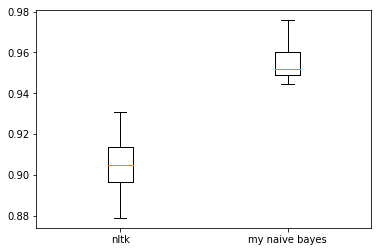

In [104]:
plt.boxplot([accuracy_nltk, accuracy], labels=["nltk", "my naive bayes"])
plt.show()